only four assay model needed to build
- heat shock response signalling agonist
- aryl hydrocarbon receptor agonist
- estrogen receptor alpha agonist
- pregnane x receptor agonist

# To do list 

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
# mpl.style.available

In [3]:
mpl.style.use('seaborn-notebook')

# Dataset Loading

In [4]:
df_tox21_raw     = pd.read_csv('data/Tox21_data.csv', sep=',')

## Data preprocessing

In [5]:
# reading the "inactive" dataset
df_labeled = pd.read_csv('data/train.csv', sep=',')
df_heat= df_labeled[df_labeled["selected_mechanism"]=='heat shock response signalling agonist'].copy()

df_inactive = df_heat[(df_heat["ASSAY_OUTCOME"]=="inactive")].copy()
df_heat_active   = df_heat[(df_heat["ASSAY_OUTCOME"]=="active")].copy()

df_inactive.drop(["ASSAY_OUTCOME"], axis=1, inplace=True)
df_heat_active.drop(["ASSAY_OUTCOME"], axis=1, inplace=True)  

df_heat.drop(["selected_mechanism", "Compound_ID"], axis=1, inplace=True)

In [6]:
df_tox21 = df_tox21_raw.copy()

In [7]:
df_tox21.dropna(subset=['Compound_ID'], inplace=True)
df_tox21.drop(["ImageID", "Plate", "Plate_Well", "batch_id", "pertType", "Batch nr", "PlateID", "Well"], axis=1, inplace=True)

# remove all heat(including both active and inactive)
df_tox21 = df_tox21[df_tox21.Tox21_assay != "heat shock response signalling agonist"]
# add heat_active
df_heat_active.rename(columns={'selected_mechanism':'Tox21_assay'}, inplace = True)
df_tox21 = pd.concat([df_tox21, df_heat_active], axis=0)

df_inactive.drop(["Compound_ID"], axis=1, inplace=True)
df_tox21 = df_tox21.groupby(['Tox21_assay','Compound_ID']).mean()

In [8]:
# drop zero variance column
threshold = 0
col_zero_var = df_tox21.std()[df_tox21.std() == threshold].index.values

df_tox21.drop(col_zero_var, axis=1, inplace=True)
df_heat.drop(col_zero_var, axis=1, inplace=True)
df_inactive.drop(col_zero_var, axis=1, inplace=True)

In [9]:
mech_lst_sub = ['heat shock response signalling agonist', 'pregnane x receptor agonist', 'estrogen receptor alpha agonist', 'aryl hydrocarbon receptor agonist']

# Model Building

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, LeaveOneOut
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, roc_curve, auc, accuracy_score
from sklearn.metrics import confusion_matrix
from numpy import interp
from sklearn.model_selection import cross_val_score

def loo_eva(pipe, df):
    X, y = df.iloc[:,1:-2].values, df.iloc[:,-1].values                           # reading the dataset, y is the label(control vs the mechanism)

    le = LabelEncoder()
    y = le.fit_transform(y)                                                       # convert the text label into 0 or 1
    
    loo = LeaveOneOut()
    kfold = loo.split(X, y)
    
    labels = []
    preds  = []
    
    for k, (train, valid) in enumerate(kfold):
        pipe.fit(X[train], y[train])
        preds.append(pipe.predict(X[valid]))
        labels.append(y[valid])

    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds)
    precision = precision_score(labels, preds)
    recall = recall_score(labels, preds)
    fpr, tpr, threshold = roc_curve(labels, preds)
    roc_auc = auc(fpr, tpr)
    
    return acc, f1, precision, recall, fpr, tpr, roc_auc

def gen_df(df, mech):
    df_mech = df.loc[mech]
    df_cont = df_inactive
    
    df_mech['selected_mechanism']=['mech']*len(df_mech) # add label
    df_cont['selected_mechanism']=['cont']*len(df_cont) # add label
    
    df_concat = pd.concat([df_mech, df_cont], axis=0) # concat 2 dataframe together to form the training dataset
    df_concat.reset_index(drop=True, inplace=True)                                 # reset all index from the oringinal datset
    return df_concat

# appraoch 1(random negative sampling appraoch)
def mech_vs_other(mech_lst, pipe):
    acc_lst = []
    f1_lst = []
    pre_lst = []
    rec_lst = []
    auc_lst = []
    fpr_lst = []
    tpr_lst = []
    
    print(f'{"mech":40} : {"accuracy":3}  {"f1 score":3}  {"AUC":3}')
    
    # separated mechanism
    for mech in mech_lst:
        df_train = gen_df(df_tox21, mech)
        acc, f1, pre, rec, fpr, tpr, roc_auc = loo_eva(pipe, df_train)
        
        print(f'{mech:>40} : {acc:.3f} {f1:.3f} {roc_auc:.3f}')
    
        acc_lst.append(acc)
        f1_lst.append(f1)
        pre_lst.append(pre)
        rec_lst.append(rec)
        auc_lst.append(roc_auc)
        fpr_lst.append(fpr)
        tpr_lst.append(tpr)
    
    print(f'Average accuracy:{np.mean(acc_lst):.3f}, Average f1 score: {np.mean(f1_lst):.3f},  Average AUC: {np.mean(auc_lst):.3f}')

    stat_1 = pd.DataFrame([mech_lst, acc_lst, f1_lst, pre_lst, rec_lst, fpr_lst, tpr_lst, auc_lst], 
                          index=['mech', 'accuracy_1', 'f1_score_1', 'precision_1', 'recall_1', 'fpr_1', 'tpr_1', 'roc_auc_1'])
    return stat_1

## Logistic regression

- https://stackoverflow.com/questions/62658215/convergencewarning-lbfgs-failed-to-converge-status-1-stop-total-no-of-iter
- https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-definitions/52388406#52388406

In [11]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=10),
                        lr)

In [12]:
print("mech vs other mech")
print('Logistic regression')

lr_stat = mech_vs_other(mech_lst_sub, pipe_lr)

mech vs other mech
Logistic regression
mech                                     : accuracy  f1 score  AUC
  heat shock response signalling agonist : 1.000 1.000 1.000
             pregnane x receptor agonist : 0.895 0.800 0.842
         estrogen receptor alpha agonist : 1.000 1.000 1.000
       aryl hydrocarbon receptor agonist : 1.000 1.000 1.000
Average accuracy:0.974, Average f1 score: 0.950,  Average AUC: 0.961


In [13]:
lr_stat

,0,1,2,3
mech,heat shock response signalling agonist,pregnane x receptor agonist,estrogen receptor alpha agonist,aryl hydrocarbon receptor agonist
accuracy_1,1.0,0.894737,1.0,1.0
f1_score_1,1.0,0.8,1.0,1.0
precision_1,1.0,0.909091,1.0,1.0
recall_1,1.0,0.714286,1.0,1.0
fpr_1,"[0.0, 0.0, 1.0]","[0.0, 0.029850746268656716, 1.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]"
tpr_1,"[0.0, 1.0, 1.0]","[0.0, 0.7142857142857143, 1.0]","[0.0, 1.0, 1.0]","[0.0, 1.0, 1.0]"
roc_auc_1,1.0,0.842217,1.0,1.0


## Decision Tree

In [14]:
from sklearn.tree import DecisionTreeClassifier

# Decision tree don't need standardization
dt = DecisionTreeClassifier(max_depth=2,
                            criterion='entropy')

In [15]:
print("mech vs other mech")
print('Decision Tree')

dt_stat = mech_vs_other(mech_lst_sub, dt)

mech vs other mech
Decision Tree
mech                                     : accuracy  f1 score  AUC
  heat shock response signalling agonist : 0.988 0.970 0.971
             pregnane x receptor agonist : 0.832 0.704 0.787
         estrogen receptor alpha agonist : 0.976 0.933 0.959
       aryl hydrocarbon receptor agonist : 0.988 0.971 0.993
Average accuracy:0.946, Average f1 score: 0.895,  Average AUC: 0.927


## Random Tree Forest

In [16]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(criterion='gini',
                                     n_estimators = 100,
                                     n_jobs = 2)

In [17]:
print("mech vs other mech")
print('Random Tree Forest')

rf_stat = mech_vs_other(mech_lst_sub, rf)

mech vs other mech
Random Tree Forest
mech                                     : accuracy  f1 score  AUC
  heat shock response signalling agonist : 1.000 1.000 1.000
             pregnane x receptor agonist : 0.916 0.840 0.868
         estrogen receptor alpha agonist : 0.988 0.966 0.967
       aryl hydrocarbon receptor agonist : 1.000 1.000 1.000
Average accuracy:0.976, Average f1 score: 0.951,  Average AUC: 0.959


## K Neighest neighbour

In [18]:
from sklearn.neighbors import KNeighborsClassifier 

knn = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric='minkowski')
pipe_knn = make_pipeline(StandardScaler(),
                    knn)

In [19]:
print("mech vs other mech")
print('K Neighest neighbour')

knn_stat = mech_vs_other(mech_lst_sub, pipe_knn)

mech vs other mech
K Neighest neighbour
mech                                     : accuracy  f1 score  AUC
  heat shock response signalling agonist : 0.988 0.970 0.971
             pregnane x receptor agonist : 0.853 0.731 0.802
         estrogen receptor alpha agonist : 1.000 1.000 1.000
       aryl hydrocarbon receptor agonist : 1.000 1.000 1.000
Average accuracy:0.960, Average f1 score: 0.925,  Average AUC: 0.943


## Support vector machine

In [20]:
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(),
                         #PCA(n_components=10),
                         SVC())

In [21]:
print("mech vs other mech")
print('Support Vector machine')

svc_stat = mech_vs_other(mech_lst_sub, pipe_svc)

mech vs other mech
Support Vector machine
mech                                     : accuracy  f1 score  AUC
  heat shock response signalling agonist : 1.000 1.000 1.000
             pregnane x receptor agonist : 0.926 0.857 0.875
         estrogen receptor alpha agonist : 1.000 1.000 1.000
       aryl hydrocarbon receptor agonist : 1.000 1.000 1.000
Average accuracy:0.982, Average f1 score: 0.964,  Average AUC: 0.969


## XGBoost

- https://www.kaggle.com/code/stuarthallows/using-xgboost-with-scikit-learn/notebook

In [22]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(objective="binary:logistic")

pipe_xgb = make_pipeline(StandardScaler(),
                         #PCA(n_components=10),
                         xgb_model)

In [23]:
print("mech vs other mech")
print('XGBoost')

xgb_stat = mech_vs_other(mech_lst_sub, pipe_xgb)

mech vs other mech
XGBoost
mech                                     : accuracy  f1 score  AUC
  heat shock response signalling agonist : 0.976 0.941 0.963
             pregnane x receptor agonist : 0.874 0.760 0.817
         estrogen receptor alpha agonist : 0.988 0.966 0.967
       aryl hydrocarbon receptor agonist : 1.000 1.000 1.000
Average accuracy:0.959, Average f1 score: 0.917,  Average AUC: 0.937


## Ensemble method

In [24]:
from sklearn.ensemble import VotingClassifier

estimators = [('lr', pipe_lr), ('dt', dt), ('rf', rf),('knn', pipe_knn), ('svc', pipe_svc), ('xgb', pipe_xgb)]
ensemble = VotingClassifier(estimators, 
                            voting='hard',
                            weights=[1, 1, 1, 1, 1, 1])

In [25]:
print("mech vs other mech")
print('Ensemble learning')

ens_stat = mech_vs_other(mech_lst_sub, ensemble)

mech vs other mech
Ensemble learning
mech                                     : accuracy  f1 score  AUC
  heat shock response signalling agonist : 1.000 1.000 1.000
             pregnane x receptor agonist : 0.905 0.809 0.839
         estrogen receptor alpha agonist : 0.988 0.966 0.967
       aryl hydrocarbon receptor agonist : 1.000 1.000 1.000
Average accuracy:0.973, Average f1 score: 0.944,  Average AUC: 0.951


## MLP

In [26]:
from sklearn.neural_network import MLPClassifier

mlp_model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)

pipe_mlp = make_pipeline(StandardScaler(),
                         #PCA(n_components=10),
                         mlp_model)

In [27]:
print("mech vs other mech")
print('MLP')

mlp_stat = mech_vs_other(mech_lst_sub, pipe_mlp)

mech vs other mech
MLP
mech                                     : accuracy  f1 score  AUC
  heat shock response signalling agonist : 0.988 0.971 0.993
             pregnane x receptor agonist : 0.905 0.824 0.860
         estrogen receptor alpha agonist : 0.976 0.933 0.959
       aryl hydrocarbon receptor agonist : 0.988 0.971 0.993
Average accuracy:0.964, Average f1 score: 0.925,  Average AUC: 0.951


# Comparing different methods

- Why svm does not perform well in our data set
    - https://www.quora.com/When-does-the-logistic-regression-perform-better-than-a-linear-SVM

In [28]:
lr_stat  = lr_stat.T.reset_index(drop=True).T
dt_stat  = dt_stat.T.reset_index(drop=True).T
rf_stat  = rf_stat.T.reset_index(drop=True).T
knn_stat = knn_stat.T.reset_index(drop=True).T
svc_stat = svc_stat.T.reset_index(drop=True).T
xgb_stat = xgb_stat.T.reset_index(drop=True).T
ens_stat = ens_stat.T.reset_index(drop=True).T
mlp_stat = mlp_stat.T.reset_index(drop=True).T

In [29]:
all_stat_index = ['mech', 'accuracy_lr',  'f1_score_lr',   'precision_lr',  'recall_lr',  'fpr_lr',  'tpr_lr',  'roc_auc_lr', 
                  '-',    'accuracy_dt',  'f1_score_dt',   'precision_dt',  'recall_dt',  'fpr_dt',  'tpr_dt',  'roc_auc_dt', 
                  '-',    'accuracy_rf',  'f1_score_rf',   'precision_rf',  'recall_rf',  'fpr_rf',  'tpr_rf',  'roc_auc_rf', 
                  '-',    'accuracy_knn', 'f1_score_knn',  'precision_knn', 'recall_knn', 'fpr_knn', 'tpr_knn', 'roc_auc_knn', 
                  '-',    'accuracy_svc', 'f1_score_svc',  'precision_svc', 'recall_svc', 'fpr_svc', 'tpr_svc', 'roc_auc_svc', 
                  '-',    'accuracy_xgb', 'f1_score_xgb',  'precision_xgb', 'recall_xgb', 'fpr_xgb', 'tpr_xgb', 'roc_auc_xgb', 
                  '-',    'accuracy_ens', 'f1_score_ens',  'precision_ens', 'recall_ens', 'fpr_ens', 'tpr_ens', 'roc_auc_ens', 
                  '-',    'accuracy_mlp', 'f1_score_mlp',  'precision_mlp', 'recall_mlp', 'fpr_mlp', 'tpr_mlp', 'roc_auc_mlp']

all_stat = (pd.concat([lr_stat, dt_stat, rf_stat, knn_stat, svc_stat, xgb_stat, ens_stat, mlp_stat], axis=0)).reset_index(drop=True)
all_stat.set_axis(all_stat_index, axis=0, inplace=True)

### ROC

heat shock response signalling agonist


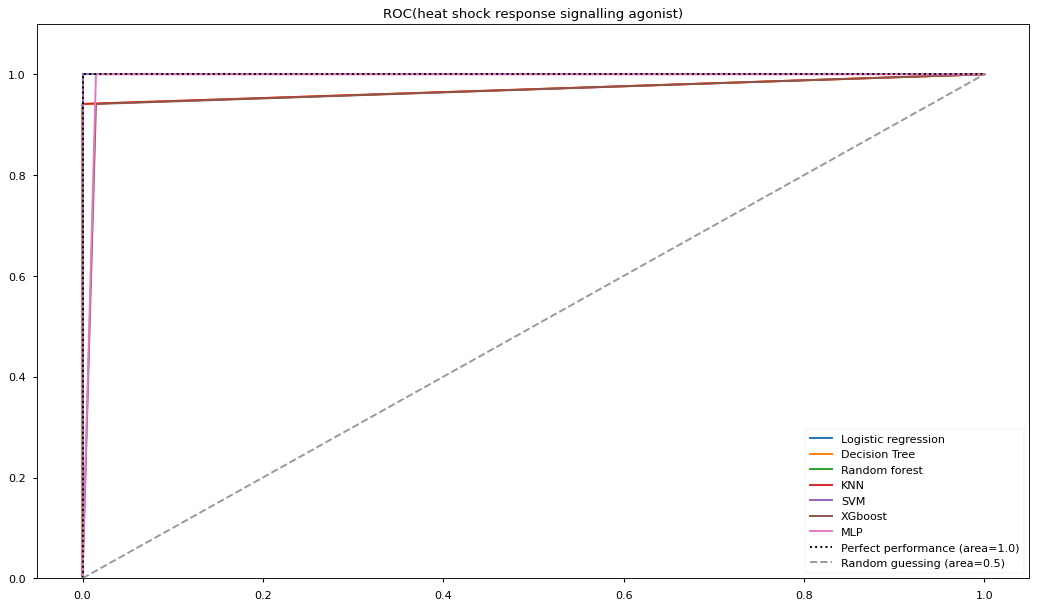

In [30]:
figure(figsize=(16, 9), dpi=80)

i = 0
print(all_stat[i]['mech'])

plt.title('ROC(heat shock response signalling agonist)')
plt.plot(all_stat[i]['fpr_lr'], all_stat[i]['tpr_lr'], label='Logistic regression')
plt.plot(all_stat[i]['fpr_dt'], all_stat[i]['tpr_dt'], label='Decision Tree')
plt.plot(all_stat[i]['fpr_rf'], all_stat[i]['tpr_rf'], label='Random forest')
plt.plot(all_stat[i]['fpr_knn'], all_stat[i]['tpr_knn'], label='KNN')
plt.plot(all_stat[i]['fpr_svc'], all_stat[i]['tpr_svc'], label='SVM')
plt.plot(all_stat[i]['fpr_xgb'], all_stat[i]['tpr_xgb'], label='XGboost')
#plt.plot(all_stat[i]['fpr_ens'], all_stat[i]['tpr_ens'], label='Ensemble')
plt.plot(all_stat[i]['fpr_mlp'], all_stat[i]['tpr_mlp'], label='MLP')

plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='black', label='Perfect performance (area=1.0)')
plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='Random guessing (area=0.5)')
plt.legend(loc='lower right')
plt.ylim((0,1.1))
plt.show()

In [31]:
all_stat = all_stat.sort_values(by = "f1_score_ens", axis=1, ascending = False)

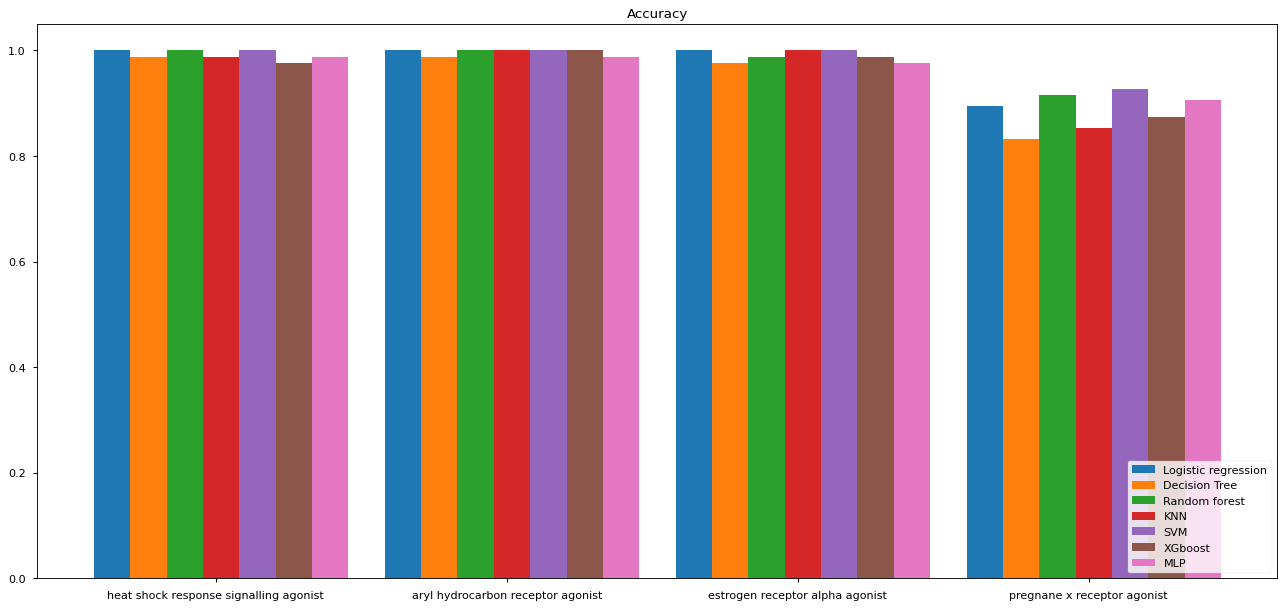

In [32]:
figure(figsize=(20, 9), dpi=80)
X = np.arange(4)
labels = all_stat.loc['mech']
width = 1/8


plt.title("Accuracy")
plt.bar(X+(width*0), all_stat.loc['accuracy_lr'], width, label="Logistic regression")
plt.bar(X+(width*1), all_stat.loc['accuracy_dt'], width, label="Decision Tree")
plt.bar(X+(width*2), all_stat.loc['accuracy_rf'], width, label="Random forest")
plt.bar(X+(width*3), all_stat.loc['accuracy_knn'], width, label="KNN")
plt.bar(X+(width*4), all_stat.loc['accuracy_svc'], width, label="SVM")
plt.bar(X+(width*5), all_stat.loc['accuracy_xgb'], width, label="XGboost")
plt.bar(X+(width*6), all_stat.loc['accuracy_mlp'], width, label="MLP")
#plt.bar(X+(width*7), all_stat.loc['accuracy_ens'], width, label="Ensemble")
plt.xticks(X+(2.5/7), labels, rotation=0)
plt.legend(loc='lower right')

plt.show()

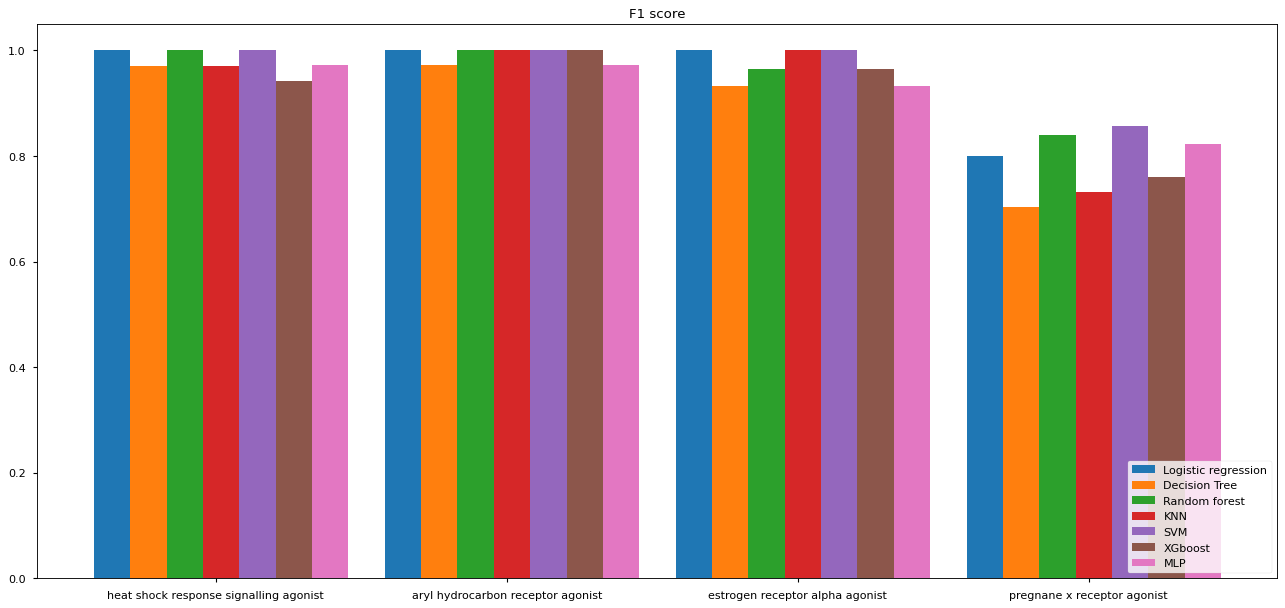

In [33]:
figure(figsize=(20, 9), dpi=80)
X = np.arange(4)
labels = all_stat.loc['mech']

plt.title("F1 score")
plt.bar(X+(width*0), all_stat.loc['f1_score_lr'], width, label="Logistic regression")
plt.bar(X+(width*1), all_stat.loc['f1_score_dt'], width, label="Decision Tree")
plt.bar(X+(width*2), all_stat.loc['f1_score_rf'], width, label="Random forest")
plt.bar(X+(width*3), all_stat.loc['f1_score_knn'], width, label="KNN")
plt.bar(X+(width*4), all_stat.loc['f1_score_svc'], width, label="SVM")
plt.bar(X+(width*5), all_stat.loc['f1_score_xgb'], width, label="XGboost")
plt.bar(X+(width*6), all_stat.loc['f1_score_mlp'], width, label="MLP")
#plt.bar(X+(width*7), all_stat.loc['f1_score_ens'], width, label="Ensemble")
plt.xticks(X+(2.5/7), labels, rotation=0)
plt.legend(loc='lower right')

plt.show()

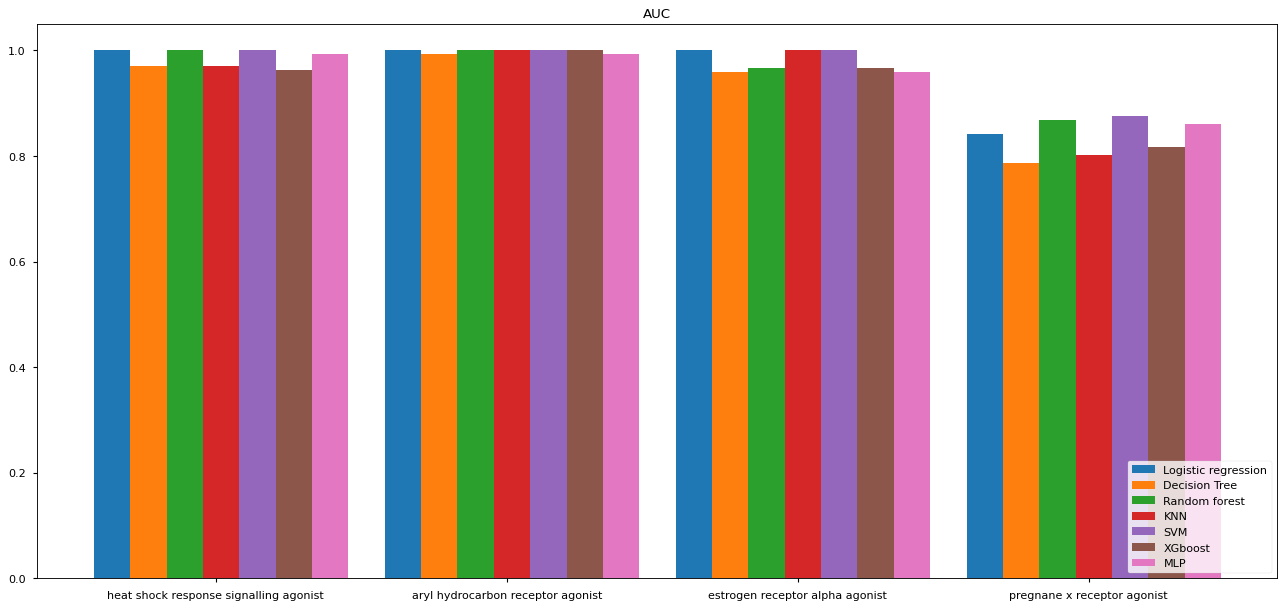

In [34]:
figure(figsize=(20, 9), dpi=80)
X = np.arange(4)
labels = all_stat.loc['mech']

plt.title("AUC")
plt.bar(X+(width*0), all_stat.loc['roc_auc_lr'], width, label="Logistic regression")
plt.bar(X+(width*1), all_stat.loc['roc_auc_dt'], width, label="Decision Tree")
plt.bar(X+(width*2), all_stat.loc['roc_auc_rf'], width, label="Random forest")
plt.bar(X+(width*3), all_stat.loc['roc_auc_knn'], width, label="KNN")
plt.bar(X+(width*4), all_stat.loc['roc_auc_svc'], width, label="SVM")
plt.bar(X+(width*5), all_stat.loc['roc_auc_xgb'], width, label="XGboost")
plt.bar(X+(width*6), all_stat.loc['roc_auc_mlp'], width, label="MLP")
#plt.bar(X+(width*7), all_stat.loc['roc_auc_ens'], width, label="Ensemble")
plt.xticks(X+(2.5/7), labels, rotation=0)
plt.legend(loc='lower right')

plt.show()

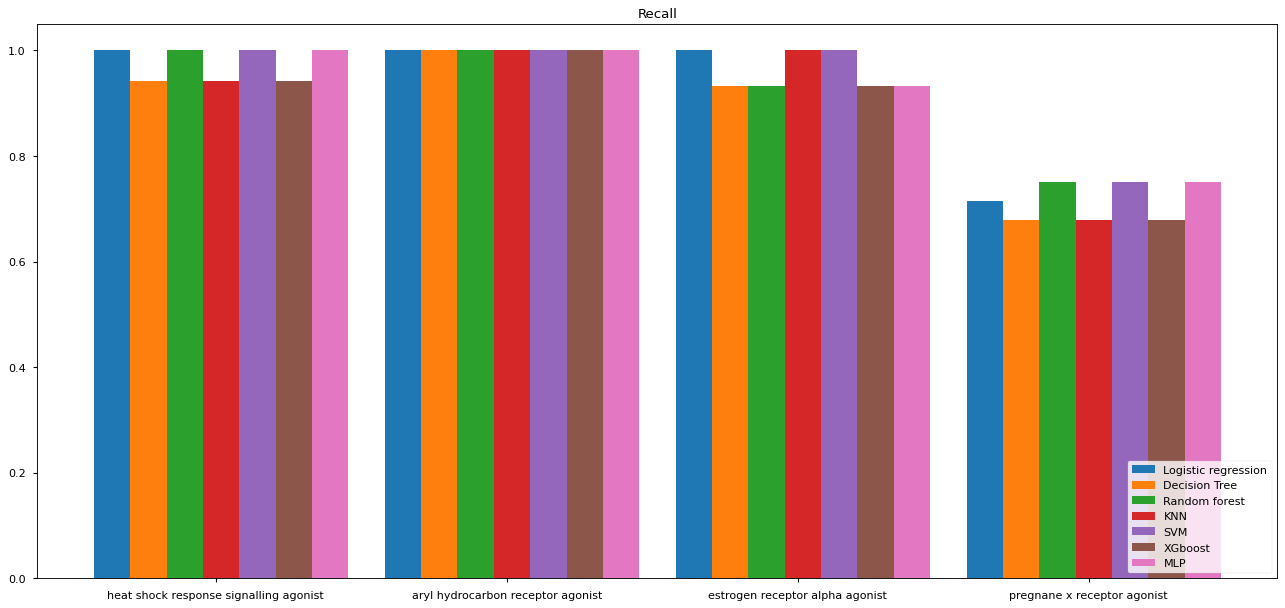

In [35]:
figure(figsize=(20, 9), dpi=80)
X = np.arange(4)
labels = all_stat.loc['mech']

plt.title("Recall")
plt.bar(X+(width*0), all_stat.loc['recall_lr'], width, label="Logistic regression")
plt.bar(X+(width*1), all_stat.loc['recall_dt'], width, label="Decision Tree")
plt.bar(X+(width*2), all_stat.loc['recall_rf'], width, label="Random forest")
plt.bar(X+(width*3), all_stat.loc['recall_knn'], width, label="KNN")
plt.bar(X+(width*4), all_stat.loc['recall_svc'], width, label="SVM")
plt.bar(X+(width*5), all_stat.loc['recall_xgb'], width, label="XGboost")
plt.bar(X+(width*6), all_stat.loc['recall_mlp'], width, label="MLP")
#plt.bar(X+(width*7), all_stat.loc['roc_auc_ens'], width, label="Ensemble")
plt.xticks(X+(2.5/7), labels, rotation=0)
plt.legend(loc='lower right')

plt.show()

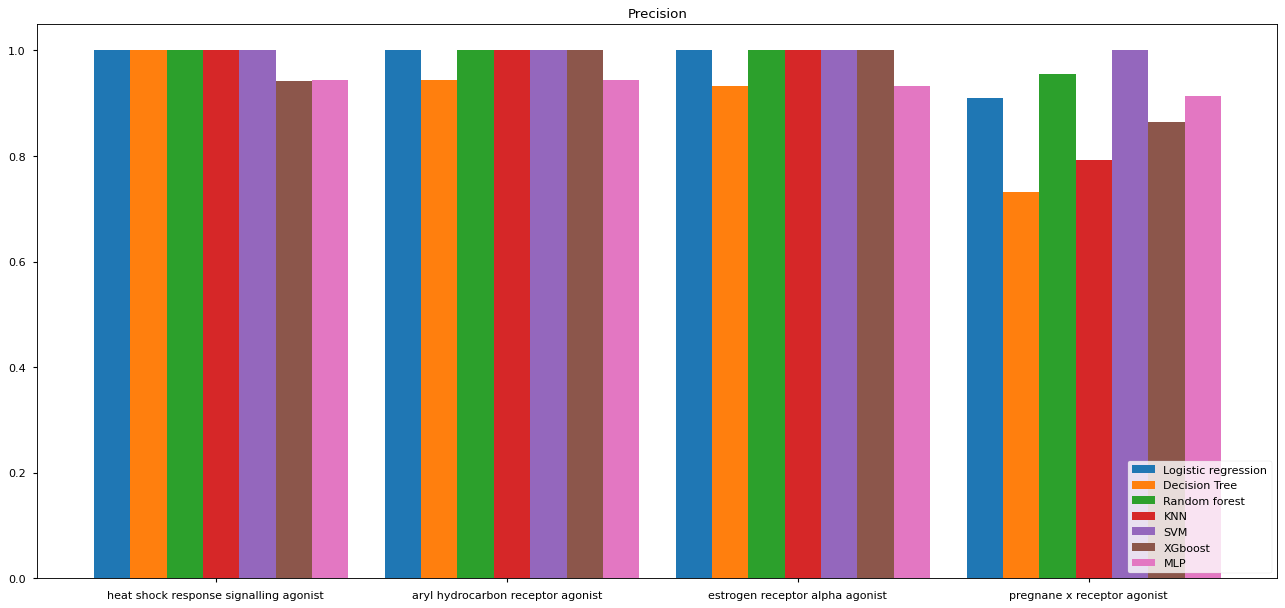

In [36]:
figure(figsize=(20, 9), dpi=80)
X = np.arange(4)
labels = all_stat.loc['mech']

plt.title("Precision")
plt.bar(X+(width*0), all_stat.loc['precision_lr'], width, label="Logistic regression")
plt.bar(X+(width*1), all_stat.loc['precision_dt'], width, label="Decision Tree")
plt.bar(X+(width*2), all_stat.loc['precision_rf'], width, label="Random forest")
plt.bar(X+(width*3), all_stat.loc['precision_knn'], width, label="KNN")
plt.bar(X+(width*4), all_stat.loc['precision_svc'], width, label="SVM")
plt.bar(X+(width*5), all_stat.loc['precision_xgb'], width, label="XGboost")
plt.bar(X+(width*6), all_stat.loc['precision_mlp'], width, label="MLP")
#plt.bar(X+(width*7), all_stat.loc['roc_auc_ens'], width, label="Ensemble")
plt.xticks(X+(2.5/7), labels, rotation=0)
plt.legend(loc='lower right')

plt.show()

In [37]:
all_stat

,0,3,2,1
mech,heat shock response signalling agonist,aryl hydrocarbon receptor agonist,estrogen receptor alpha agonist,pregnane x receptor agonist
accuracy_lr,1.0,1.0,1.0,0.894737
f1_score_lr,1.0,1.0,1.0,0.8
precision_lr,1.0,1.0,1.0,0.909091
recall_lr,1.0,1.0,1.0,0.714286
...,...,...,...,...
precision_mlp,0.944444,0.944444,0.933333,0.913043
recall_mlp,1.0,1.0,0.933333,0.75
fpr_mlp,"[0.0, 0.014925373134328358, 1.0]","[0.0, 0.014925373134328358, 1.0]","[0.0, 0.014925373134328358, 1.0]","[0.0, 0.029850746268656716, 1.0]"
tpr_mlp,"[0.0, 1.0, 1.0]","[0.0, 1.0, 1.0]","[0.0, 0.9333333333333333, 1.0]","[0.0, 0.75, 1.0]"


# Conformal prediction

https://towardsdatascience.com/how-to-add-uncertainty-estimation-to-your-models-with-conformal-prediction-a5acdb86ea05

In [38]:
# Import the required packages
import sys
sys.path.append('src')
import numpy as np
from nonconformist.cp import IcpClassifier, TcpClassifier,IcpRegressor
from nonconformist.nc import ClassifierNc, MarginErrFunc, ClassifierAdapter, RegressorNc, AbsErrorErrFunc

from pharmbio.cp import metrics
from pharmbio.cp import plotting # this import causes seaborn style be set if available on the path
import matplotlib.pyplot as plt
import seaborn as sns


# Set the figure size to re-use so it fits the screen OK
fig_size = (14,7)
# Set a different context, default is "notebook" - so that all fonts are enlarged
#sns.set_context("talk")

### heat shock

### ICP

In [49]:
X, y = df_heat.iloc[:,0:-1].values, df_heat.iloc[:,-1].values                           # reading the dataset, y is the label(control vs the mechanism)

le = LabelEncoder()
y = le.fit_transform(y)                                                                 # convert the text label into 0 or 1
    
loo = LeaveOneOut()
kfold = loo.split(X, y)
    
labels  = []
preds   = [[0,0]]
pvalues = [[0,0]]

icp = IcpClassifier(ClassifierNc(ClassifierAdapter(pipe_xgb), MarginErrFunc()))

for k, (train, valid) in enumerate(kfold):
    X_train, X_calib, y_train, y_calib = train_test_split(X[train], y[train], test_size=0.2, stratify=y[train])
    
    # Train the ICP
    icp.fit(X_train, y_train) # First train the underlying model
    icp.calibrate(X_calib,y_calib) # Calibrate the ICP

    pred = icp.predict(X[valid], significance=.05) # i.e. 95% confidence - we get a matrix for the included classes
    pvalue = icp.predict(X[valid]) # Or no significance - get the raw p-values

    pvalues = pvalues+ list(pvalue)
    preds = preds + list(pred)
    labels.append(int(y[valid]))

pvalues = pvalues[1:]
preds = preds[1:]

In [50]:
obs_fuzz = metrics.obs_fuzziness(labels,pvalues)
print("Observed fuzziness: %.3f" % obs_fuzz)

CM = metrics.confusion_matrix(labels, pvalues, sign=0.2, labels=le.inverse_transform(np.unique(y)))
print('Confusion matrix using significance \u03B5=0.2\n')
CM

Observed fuzziness: 0.043
Confusion matrix using significance ε=0.2



,active,inactive
active,1,0
inactive,3,64
Empty,13,3
Both,0,0


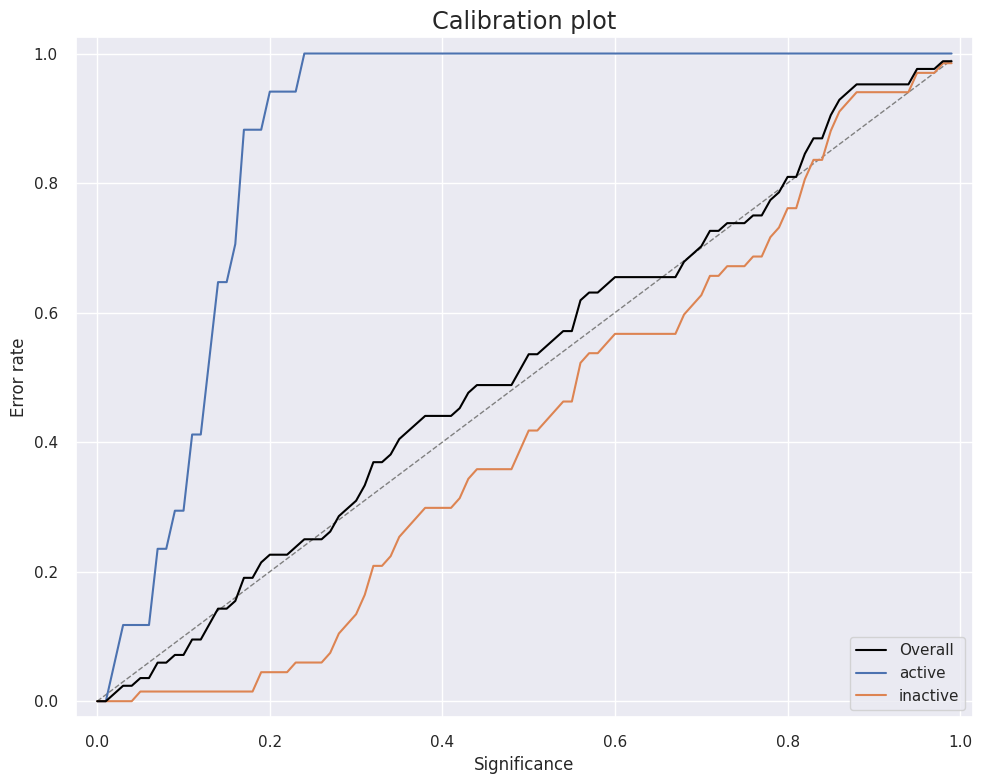

In [51]:
# Perhaps most important, the calibration plot:
calib_fig = plotting.plot_calibration_curve(labels, 
                                            pvalues, 
                                            title='Calibration plot',
                                            labels=le.inverse_transform(np.unique(y)),
                                            figsize=None)
plt.show()

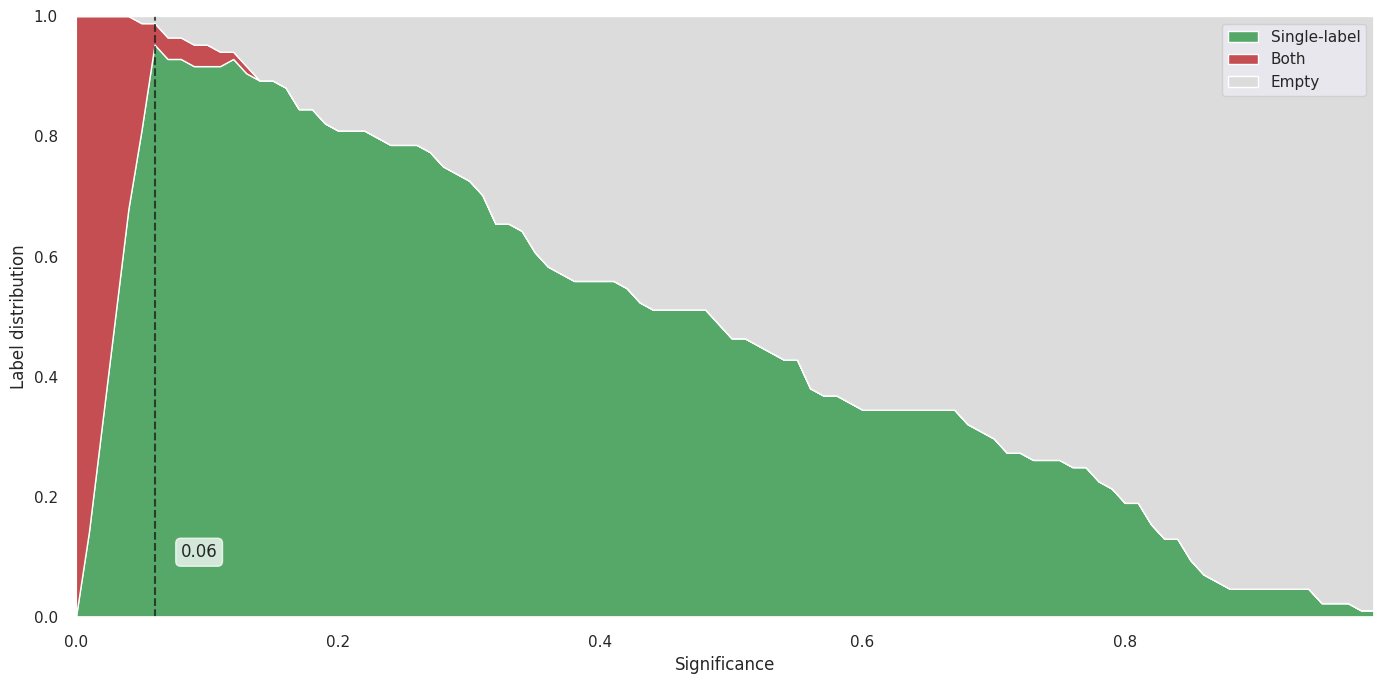

In [52]:
label_distr_fig = plotting.plot_label_distribution(labels,
                                                   pvalues,
                                                   sign_vals=np.arange(0,1,0.01),
                                                   mark_best=True,
                                                   display_incorrects=False,
                                                   figsize = fig_size)

plt.show()

### TCP

In [53]:
X, y = df_heat.iloc[:,0:-1].values, df_heat.iloc[:,-1].values                           # reading the dataset, y is the label(control vs the mechanism)

le = LabelEncoder()
y = le.fit_transform(y)                                                                 # convert the text label into 0 or 1
    
loo = LeaveOneOut()
kfold = loo.split(X, y)
    
labels  = []
preds   = [[0,0]]
pvalues = [[0,0]]

tcp = TcpClassifier(ClassifierNc(ClassifierAdapter(pipe_xgb), MarginErrFunc()))

for k, (train, valid) in enumerate(kfold):
    # Train the ICP
    tcp.fit(X[train], y[train]) # First train the underlying model

    pred = tcp.predict(X[valid], significance=.05) # i.e. 95% confidence - we get a matrix for the included classes
    pvalue = tcp.predict(X[valid]) # Or no significance - get the raw p-values

    pvalues = pvalues+ list(pvalue)
    preds = preds + list(pred)
    labels.append(int(y[valid]))

pvalues = pvalues[1:]
preds = preds[1:]

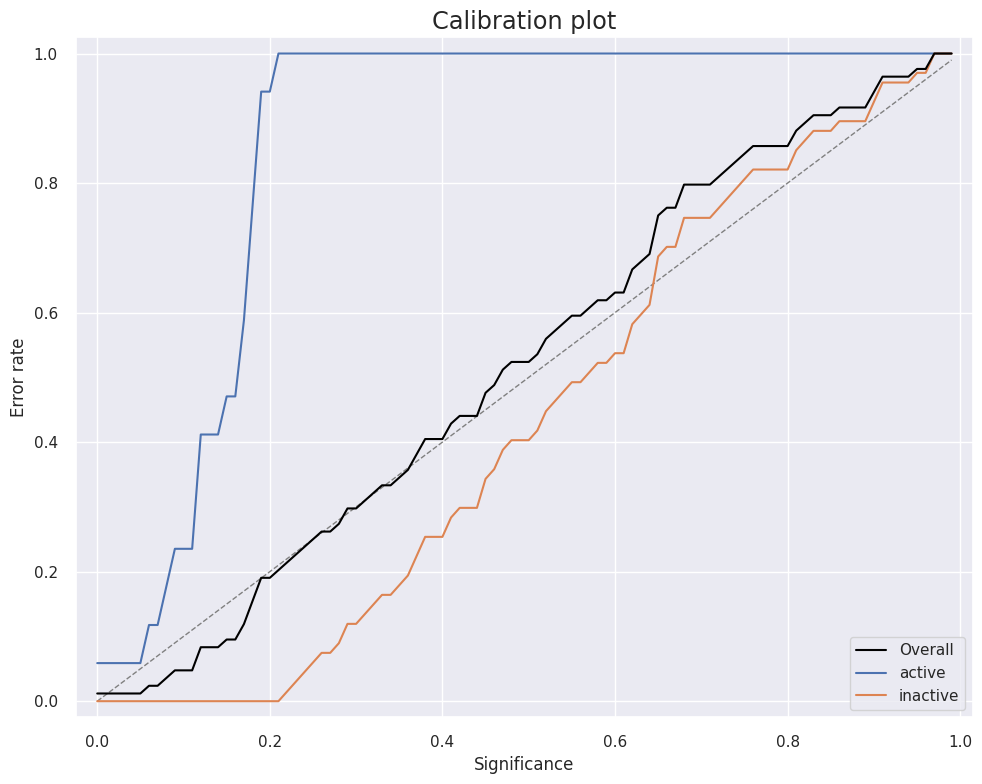

In [54]:
# Perhaps most important, the calibration plot:
calib_fig = plotting.plot_calibration_curve(labels, 
                                            pvalues, 
                                            title='Calibration plot',
                                            labels=le.inverse_transform(np.unique(y)),
                                            figsize=None)
plt.show()

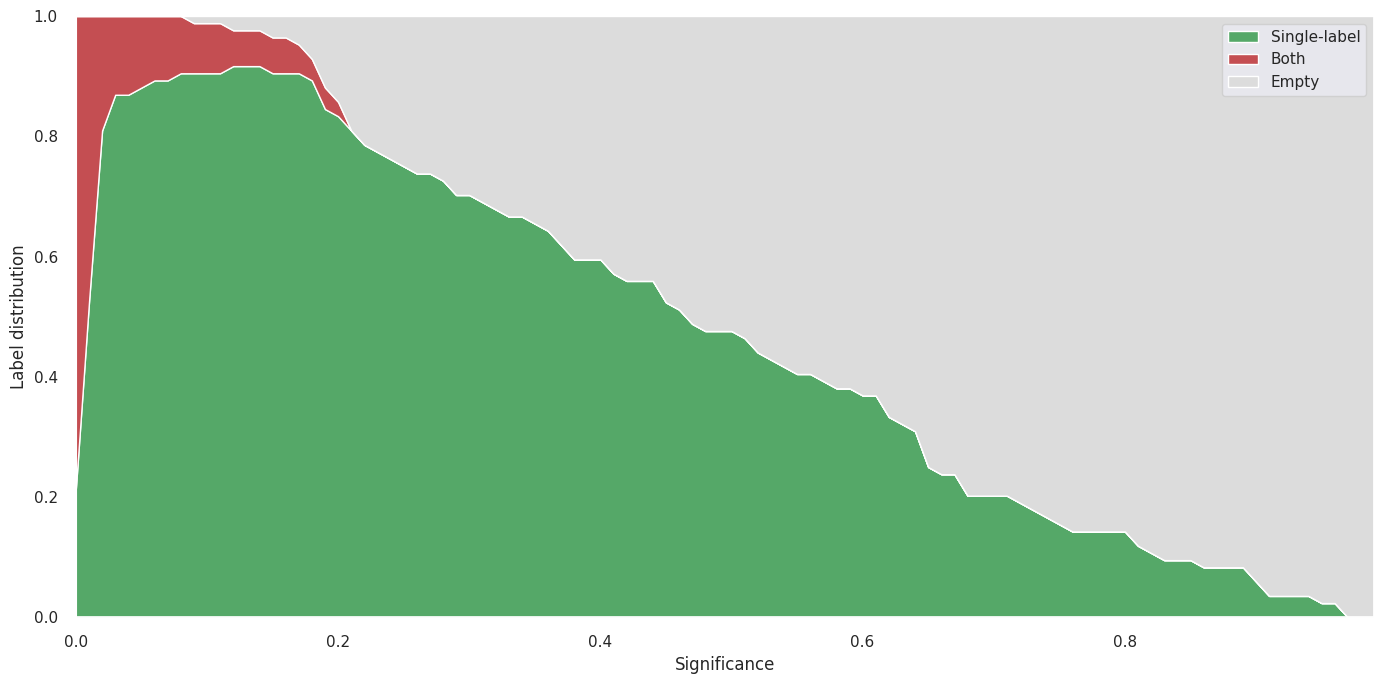

In [55]:
# Comparing the results from ICP and TCP can now be performed using e.g. the label distribution plot
label_distr_tcp_fig = plotting.plot_label_distribution(labels,
                                                       pvalues,
                                                       sign_vals=np.arange(0,1,0.01),
                                                       mark_best=False,
                                                       display_incorrects=False,
                                                       figsize=fig_size)
plt.show()